# The Scrape phase
The objective here is to scrape some text and other meta-data from popular math blogs

In [62]:
from selenium import webdriver # The workhorse of this operation
from time import sleep # so we don't scrape too fast and get kicked out
import pandas as pd # for capturing the data in a tabular form
import string # for cleaning strings
import re # regular expressions for cleaning up some strings

In [70]:
driver = webdriver.Firefox()
driver.get('https://blog.feedspot.com/math_blogs/')

In [71]:
bname_selectors = driver.find_elements_by_class_name('tlink')
math_selectors = driver.find_elements_by_class_name('ext')
text_selectors = driver.find_elements_by_xpath('//p[contains(@class,"trow trow-wrap")]')

C:\Users\jandr\AppData\Local\Temp\ipykernel_9964\2959574263.py:1: DeprecationWarning: find_elements_by_class_name is deprecated. Please use find_elements(by=By.CLASS_NAME, value=name) instead
  bname_selectors = driver.find_elements_by_class_name('tlink')
C:\Users\jandr\AppData\Local\Temp\ipykernel_9964\2959574263.py:2: DeprecationWarning: find_elements_by_class_name is deprecated. Please use find_elements(by=By.CLASS_NAME, value=name) instead
  math_selectors = driver.find_elements_by_class_name('ext')
C:\Users\jandr\AppData\Local\Temp\ipykernel_9964\2959574263.py:3: DeprecationWarning: find_elements_by_xpath is deprecated. Please use find_elements(by=By.XPATH, value=xpath) instead
  text_selectors = driver.find_elements_by_xpath('//p[contains(@class,"trow trow-wrap")]')


In [72]:
bnames = [n.text.replace('|','').replace('?',' ').replace('/',' ').replace('-','') for n in bname_selectors]
math_urls = [mu.get_attribute("href") for mu in math_selectors]
text_ext = [f.text for f in text_selectors]

In [5]:
remove_wierd_chars = lambda s: "".join(filter(lambda char: char in string.printable, s))
def extract_post_rate(s):
    post_ind = s.find(' / ')
    s1 = s[post_ind-8:post_ind+10]
    n_ind = s1.find('\n')
    if n_ind < 5:
        s1 = s1[n_ind+1:]
        n_ind = s1.find('\n')
        s1 = s1[:n_ind]
    else:
        s1 = s1[:n_ind]
    return s1.strip()

In [6]:
clean_text_ext =[remove_wierd_chars(s) for s in text_ext]
post_rate_words = [extract_post_rate(cte) for cte in clean_text_ext ]

In [7]:
# Convert post rate into numbers
time_dict = {'day': 1,
             'week': 7,
             'mon': 30,
             'quar': 90,
             'year': 360} ;
def get_daily_post_rate(prw):
    if prw=='':
        daily_post_rate = 0
    else:
        digit = int(re.findall("\d",prw)[0])
        time_iterval = re.findall("day|week|mon|quar|year",prw)

        num_days = time_dict[time_iterval[0]]
        daily_post_rate = digit / num_days
    return daily_post_rate

In [8]:
daily_post_rates = [round(get_daily_post_rate(prw),ndigits=4) for prw in post_rate_words]

In [9]:
# store the scraped data
data_dict = {'blog_name' : bnames,
             'blog_url'  : math_urls,
             'post_rate_words' : post_rate_words,
             'daily_post_rate': daily_post_rates}
df = pd.DataFrame(data_dict)
df.to_excel('scrape_text\math_blogs.xlsx')

In [31]:
# store the scraped summary text
for t in range(len(bnames)):
    file2write=open('scrape_text\\'+ bnames[t]+"_desc.txt",'w')
    file2write.write(clean_text_ext[t])
    file2write.close() 

In [63]:
df = pd.read_excel('scrape_text\math_blogs.xlsx') # loading data that you have stored

## Some preliminary observations/visualizations.

In [36]:
import matplotlib.pyplot as plt

(array([34., 10., 18.,  0.,  5.,  0.,  4.,  0.,  1.,  0.,  0.,  0.,  0.,
         0.,  3.]),
 array([0.        , 0.06666667, 0.13333333, 0.2       , 0.26666667,
        0.33333333, 0.4       , 0.46666667, 0.53333333, 0.6       ,
        0.66666667, 0.73333333, 0.8       , 0.86666667, 0.93333333,
        1.        ]),
 [<matplotlib.patches.Polygon at 0x1bb761eb3a0>])

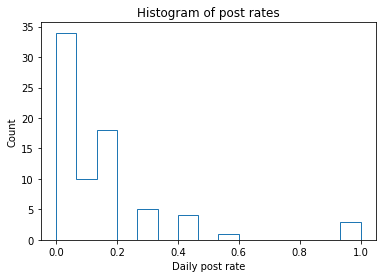

In [147]:
fig, ax = plt.subplots(nrows=1,ncols=1)
ax.set_title("Histogram of post rates");
ax.set_xlabel("Daily post rate");
ax.set_ylabel("Count");
ax.hist(df['daily_post_rate'],label="A",bins=15,histtype="step")

[]

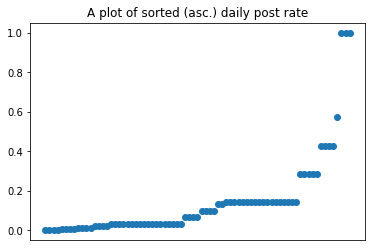

In [64]:
fig, ax = plt.subplots(nrows=1,ncols=1)
ax.set_title("A plot of sorted (asc.) daily post rate")
ax.scatter([i for i in range(75)],sorted(df['daily_post_rate']))
ax.set_xticks([])
# The flat streatches are due to the nature of our original data, e.g. posts / month etc.
# We can clearly see a powerlaw distribution as the most frequent posters distinguish them selves from the herd.

In [104]:
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from collections import Counter

In [47]:
engstopwords = nltk.corpus.stopwords.words('english') 
wordnet_lemmatizer = WordNetLemmatizer()

In [111]:
words = word_tokenize(' '.join(bnames))
lemmatized = [wordnet_lemmatizer.lemmatize(t.lower()) for t in words if t.lower() not in engstopwords]
counter = Counter(lemmatized)
most_common_words = counter.most_common(10)
w, c = zip(*most_common_words)

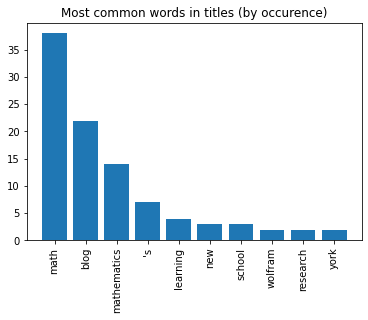

In [113]:
fig, ax = plt.subplots(nrows=1,ncols=1)
ax.set_title("Most common words in titles (by occurence)");
ax.bar(w, c)
plt.xticks(rotation=90);

# Scrape and Clean:
Since my spidermancy is lacking I have to do it somewhat manually. As such I scrape only the first 10 on the list:

In [239]:
import os
from collections import OrderedDict
def save_post_links(post_links_list, name):
    ds = pd.Series(post_links_list)
    filename = 'scrape_text\{}_post_links.xlsx'.format(name)
    ds.to_excel(filename)

In [129]:
url = df['blog_url'][0]
name = df['blog_name'][0].replace(' ','_')

## Scraping 'Stephen Wolfram Blog' 

In [120]:
driver = webdriver.Firefox()
driver.get(df['blog_url'][0])
post_links = []
for i in range(10):
    post_links_selectors = driver.find_elements_by_class_name("more-link")
    post_links.append([pls.get_attribute("href")  for pls in post_links_selectors])
    try:
        driver.find_element_by_id("__cookie-consent-button").click()
    except:
        0
    driver.find_element_by_xpath('//a[contains(@class,"page-numbers next")]').click()
    sleep(4)

In [121]:
post_links_list = [p for pl in post_links for p in pl]
save_post_links(post_links_list, name):
os.mkdir(name)
driver = webdriver.Firefox()

C:\Users\jandr\AppData\Local\Temp\ipykernel_9964\1711115682.py:4: DeprecationWarning: find_elements_by_class_name is deprecated. Please use find_elements(by=By.CLASS_NAME, value=name) instead
  post_links_selectors = driver.find_elements_by_class_name("more-link")
C:\Users\jandr\AppData\Local\Temp\ipykernel_9964\1711115682.py:7: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  driver.find_element_by_id("__cookie-consent-button").click()
C:\Users\jandr\AppData\Local\Temp\ipykernel_9964\1711115682.py:10: DeprecationWarning: find_element_by_xpath is deprecated. Please use find_element(by=By.XPATH, value=xpath) instead
  driver.find_element_by_xpath('//a[contains(@class,"page-numbers next")]').click()


In [122]:
# look up the post page and scrape the content
for pl in post_links_list[2:]:
    try:
        driver.get(pl)
        sleep(4)
        post_content = driver.find_element_by_xpath('//div[@id="content"]').text
        post_title = pl.split('/')[-2]

        file2write=open(name+'\\'+post_title+".txt",'w')
        file2write.write(remove_wierd_chars(post_content))
        file2write.close() 
    except:
        print(pl)

## Scrape Math_Only_Math
This blog is more a collection of worksheets for elementary (like elementary school) mathematics exercises. As such there is not much in the line of words to scrape.

## Math_with_Bad_Drawings
This site use an "infite" scroll bar.

In [260]:
url = df['blog_url'][2]
name = df['blog_name'][2].replace(' ','_')
driver = webdriver.Firefox()
driver.get(url)
sleep(2)

In [261]:
post_titles  = []
post_links = []
for i in range(20):
#     post_title_selectors= driver.find_elements_by_xpath('//header[@class="entry-header"]')
    post_links_selectors= driver.find_elements_by_xpath('//a[@rel="bookmark"]')
    
    post_links_temp = [pls.get_attribute("href")  for pls in post_links_selectors]
    post_links.extend(post_links_temp)
#     post_titles.extend([pls.text for pls in post_title_selectors])
    sleep(3)
    driver.execute_script("window.scrollTo(0, document.body.scrollHeight)")
    sleep(1)
    driver.execute_script("window.scrollTo(0, document.body.scrollHeight)")

C:\Users\jandr\AppData\Local\Temp\ipykernel_9964\4284507339.py:5: DeprecationWarning: find_elements_by_xpath is deprecated. Please use find_elements(by=By.XPATH, value=xpath) instead
  post_links_selectors= driver.find_elements_by_xpath('//a[@rel="bookmark"]')


In [262]:
post_links = list(OrderedDict.fromkeys(post_links))
save_post_links(post_links, name)
os.mkdir(name)

140

In [276]:
for pl in post_links[1:]:
    sleep(3)
    try:
        driver.get(pl)
    #     post_content = driver.find_element_by_xpath('//div[@class,"entry-content"]').text
        post_content = driver.find_element_by_class_name("entry-content").text
        post_title = pl.split('/')[-2]

        file2write=open(name+'\\'+post_title+".txt",'w')
        file2write.write(remove_wierd_chars(post_content))
        file2write.close() 
    except:
        print(pl)

C:\Users\jandr\AppData\Local\Temp\ipykernel_9964\495244311.py:6: DeprecationWarning: find_element_by_class_name is deprecated. Please use find_element(by=By.CLASS_NAME, value=name) instead
  post_content = driver.find_element_by_class_name("entry-content").text


## "What's_new"

In [316]:
url = df['blog_url'][3]
name = df['blog_name'][3].replace(' ','_')
driver = webdriver.Firefox()
driver.get(url)
sleep(2)

In [305]:
post_links = []
for i in range(10):
    post_header_selectors = driver.find_elements_by_xpath('//h2[@class="post-title"]//a')
    post_links.extend([phs.get_attribute('href') for phs in post_header_selectors])
    sleep(3)
    driver.execute_script("window.scrollTo(0, document.body.scrollHeight)")
    driver.execute_script("window.scrollTo(0, document.body.scrollHeight)")
    sleep(3)
    driver.execute_script("window.scrollTo(0, document.body.scrollHeight)") 
    try:
        driver.find_element_by_id("infinite-handle").find_element_by_xpath('//button').click()
    except:
        0

C:\Users\jandr\AppData\Local\Temp\ipykernel_9964\1568653550.py:3: DeprecationWarning: find_elements_by_xpath is deprecated. Please use find_elements(by=By.XPATH, value=xpath) instead
  post_header_selectors = driver.find_elements_by_xpath('//h2[@class="post-title"]//a')
C:\Users\jandr\AppData\Local\Temp\ipykernel_9964\1568653550.py:11: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  driver.find_element_by_id("infinite-handle").find_element_by_xpath('//button').click()


In [310]:
post_links = list(OrderedDict.fromkeys(post_links))
save_post_links(post_links, name)
os.mkdir(name)

In [317]:
for pl in post_links[10:]:
    sleep(3)
    try:
        driver.get(pl)
        post_content = driver.find_element_by_class_name("post-content" ).text
        post_title = pl.split('/')[-2]

        file2write=open(name+'\\'+post_title+".txt",'w')
        file2write.write(remove_wierd_chars(post_content))
        file2write.close()
    except:
        print(pl)

C:\Users\jandr\AppData\Local\Temp\ipykernel_9964\1611345891.py:5: DeprecationWarning: find_element_by_class_name is deprecated. Please use find_element(by=By.CLASS_NAME, value=name) instead
  post_content = driver.find_element_by_class_name("post-content" ).text


# Text analysis

In [18]:
import nltk
from nltk.tokenize import word_tokenize
from nltk.tokenize import sent_tokenize
from nltk.stem import WordNetLemmatizer
from collections import Counter

import os

In [69]:
def read_post(file):
    with open(file_dir+file) as f:
        lines = f.readlines()
        return ' '.join(lines).replace('\n','')
def get_number_of_chars(files):
    return [len(read_post(f)) for f in files]  
def get_number_of_words(files):
    return [len([t for t in word_tokenize(read_post(f)) if (t.lower() not in engstopwords) and (len(t) > 1 )]) for f in files ]

In [71]:
file_dir = 'scrape_text\\Stephen_Wolfram_Blog\\'
files = os.listdir(file_dir);
number_of_chars = get_number_of_chars(files)
number_of_words = get_number_of_words(files)

In [76]:
def make_hist_post_len(char_lens,s):
    fig, ax = plt.subplots(nrows=1,ncols=1)
    ax.set_title("Histogram of post lengths ({})".format(s));
    ax.set_xlabel("Number of {} per post".format(s));
    ax.set_ylabel("Count");
    ax.hist(char_lens,label="A",bins=20,histtype="step")

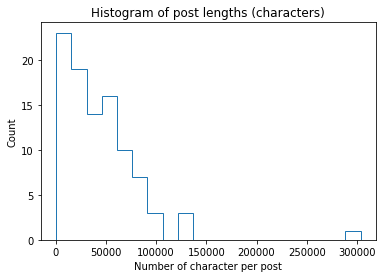

In [77]:
make_hist_post_len(char_lens,'characters')

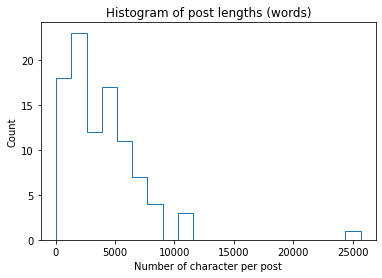

In [79]:
make_hist_post_len(number_of_words,'words')

In [56]:
from wordcloud import WordCloud

In [102]:
 with open('scrape_text//rand.txt','r',encoding='utf-8-sig') as f:
        lines = f.readlines()
        text_m = ' '.join(lines).replace('\n','')

In [111]:
words = word_tokenize(text_m)
lemmatized = [wordnet_lemmatizer.lemmatize(t.lower()) for t in words if (t.lower() not in engstopwords) and (len(t) > 1)]

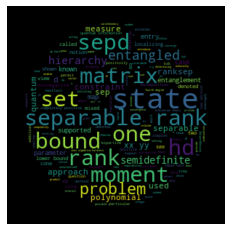

In [116]:
fig, axes = plt.subplots(1, 1)

text = ' '.join(lemmatized)
x, y = np.ogrid[:300, :300]
mask = (x - 150) ** 2 + (y - 150) ** 2 > 130 ** 2
mask = 255 * mask.astype(int)

wc = WordCloud(background_color="black",
               repeat=True,
               mask=mask)
wc.generate(text)

plt.axis("off")
plt.imshow(wc, interpolation="bilinear")
plt.show()
fig.savefig('word cloud.jpg', bbox_inches='tight', dpi=250)